In [1]:
from velocity_field import vel
from numerical_integrators.single_step import euler, rk2, rk3, rk4
from numerical_integrators.adaptive_step import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
t_min, t_max = 0, 5

h = 0.01

h_ref = np.copy(h)

x_min, x_max = 0, 2
y_min, y_max = 0, 1

Ny = 201
Nx = 1 + np.floor((Ny-1)*(x_max-x_min)/(y_max-y_min)).astype(int)

dx = (x_max - x_min)/(Nx - 1)
dy = (y_max - y_min)/(Ny - 1)

In [3]:
x0 = np.linspace(x_min, x_max, Nx)
y0 = np.linspace(y_min, y_max, Ny)

x = np.zeros(Nx*Ny)
y = np.copy(x)

for j in range(Ny):
    x[j*Nx:(j+1)*Nx] = x0
    y[j*Nx:(j+1)*Nx] = y0[j]

pos = np.array([x, y])

print(np.shape(pos))

(2, 80601)


In [4]:
left_offset = np.ones([Ny, Nx])
right_offset = np.copy(left_offset)

top_offset = np.copy(left_offset)
bottom_offset = np.copy(left_offset)

lyap = np.copy(left_offset)

print(np.shape(left_offset))

print(np.shape(pos[0].reshape(Ny,Nx)))

(201, 401)
(201, 401)


In [5]:
n_snaps = 1
t_tot = t_max - t_min
t_incr = t_tot / n_snaps

In [18]:
def timestep(t,            # Current time level
             pos,
             h,            # Timestep
             deriv,        # Function handle for the derivatives,
                           # in our case, the velocity field
             integrator    # Function handle for the numerical
                           # integrator to use, e.g., 'euler' or 'rk4'
             ):

    # All numerical integrators return the following variables:
    #    t:    New time level       (for adaptive timestep integrators,
    #                                the time level is only updated if
    #                                the trial step is accepted)
    #    x:    New coordinate array (for adaptive timestep integrators,
    #                                the coordinates are only updated
    #                                if the trial step(s) is accepted)
    #    h:    Timestep             (subject to change in adaptive
    #                                timestep integrators, otherwise
    #                                unaltered)
    t, pos, h = integrator(t,
                              pos,
                              h,
                              deriv, atol = 1e-6, rtol = 1e-6
                              )
    # We return the new time level, the updated coordinates and
    # the (updated) timestep.
    return t, pos, h

In [11]:
t = t_min
ts = np.ones(Nx*Ny)*t_min

hs = np.ones(np.shape(ts))*h_ref

In [12]:
integrator = rkbs32

In [460]:
# Now, we're ready to step forwards in time:

# First, we loop over the number of snapshots we want to generate:
for i in range(n_snaps):
    # We step forwards in time from one snapshot to the next:
    counter = 0
    while np.any(ts < t_min + (i+1)*t_incr):
        counter+=1
        hs = np.minimum(hs, t_min + (i+1)*t_incr - ts)

        ts, pos, hs = timestep(ts, pos, hs, vel, integrator)
        

    print(counter)
    xy = pos[0].reshape(Ny, Nx)
    yx = pos[1].reshape(Ny, Nx)

    left_offset[1:-2,1:-2] = np.sqrt((xy[0:-3,1:-2]-xy[1:-2,1:-2])**2
                                    +(yx[0:-3,1:-2]-yx[1:-2,1:-2])**2)

    right_offset[1:-2,1:-2] = np.sqrt((xy[2:-1,1:-2]-xy[1:-2,1:-2])**2
                                     +(yx[2:-1,1:-2]-yx[1:-2,1:-2])**2)


    top_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,0:-3]-xy[1:-2,1:-2])**2
                                   +(yx[1:-2,0:-3]-yx[1:-2,1:-2])**2)

    bottom_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,2:-1]-xy[1:-2,1:-2])**2
                                     +(yx[1:-2,2:-1]-yx[1:-2,1:-2])**2)

    lyap = np.fmax(np.log(np.fmax(left_offset,right_offset)
                  /dx)/(t_min+(i+1)*t_incr),
                  np.log(np.fmax(top_offset,bottom_offset)
                  /dy)/(t_min+(i+1)*t_incr)
                  )









997


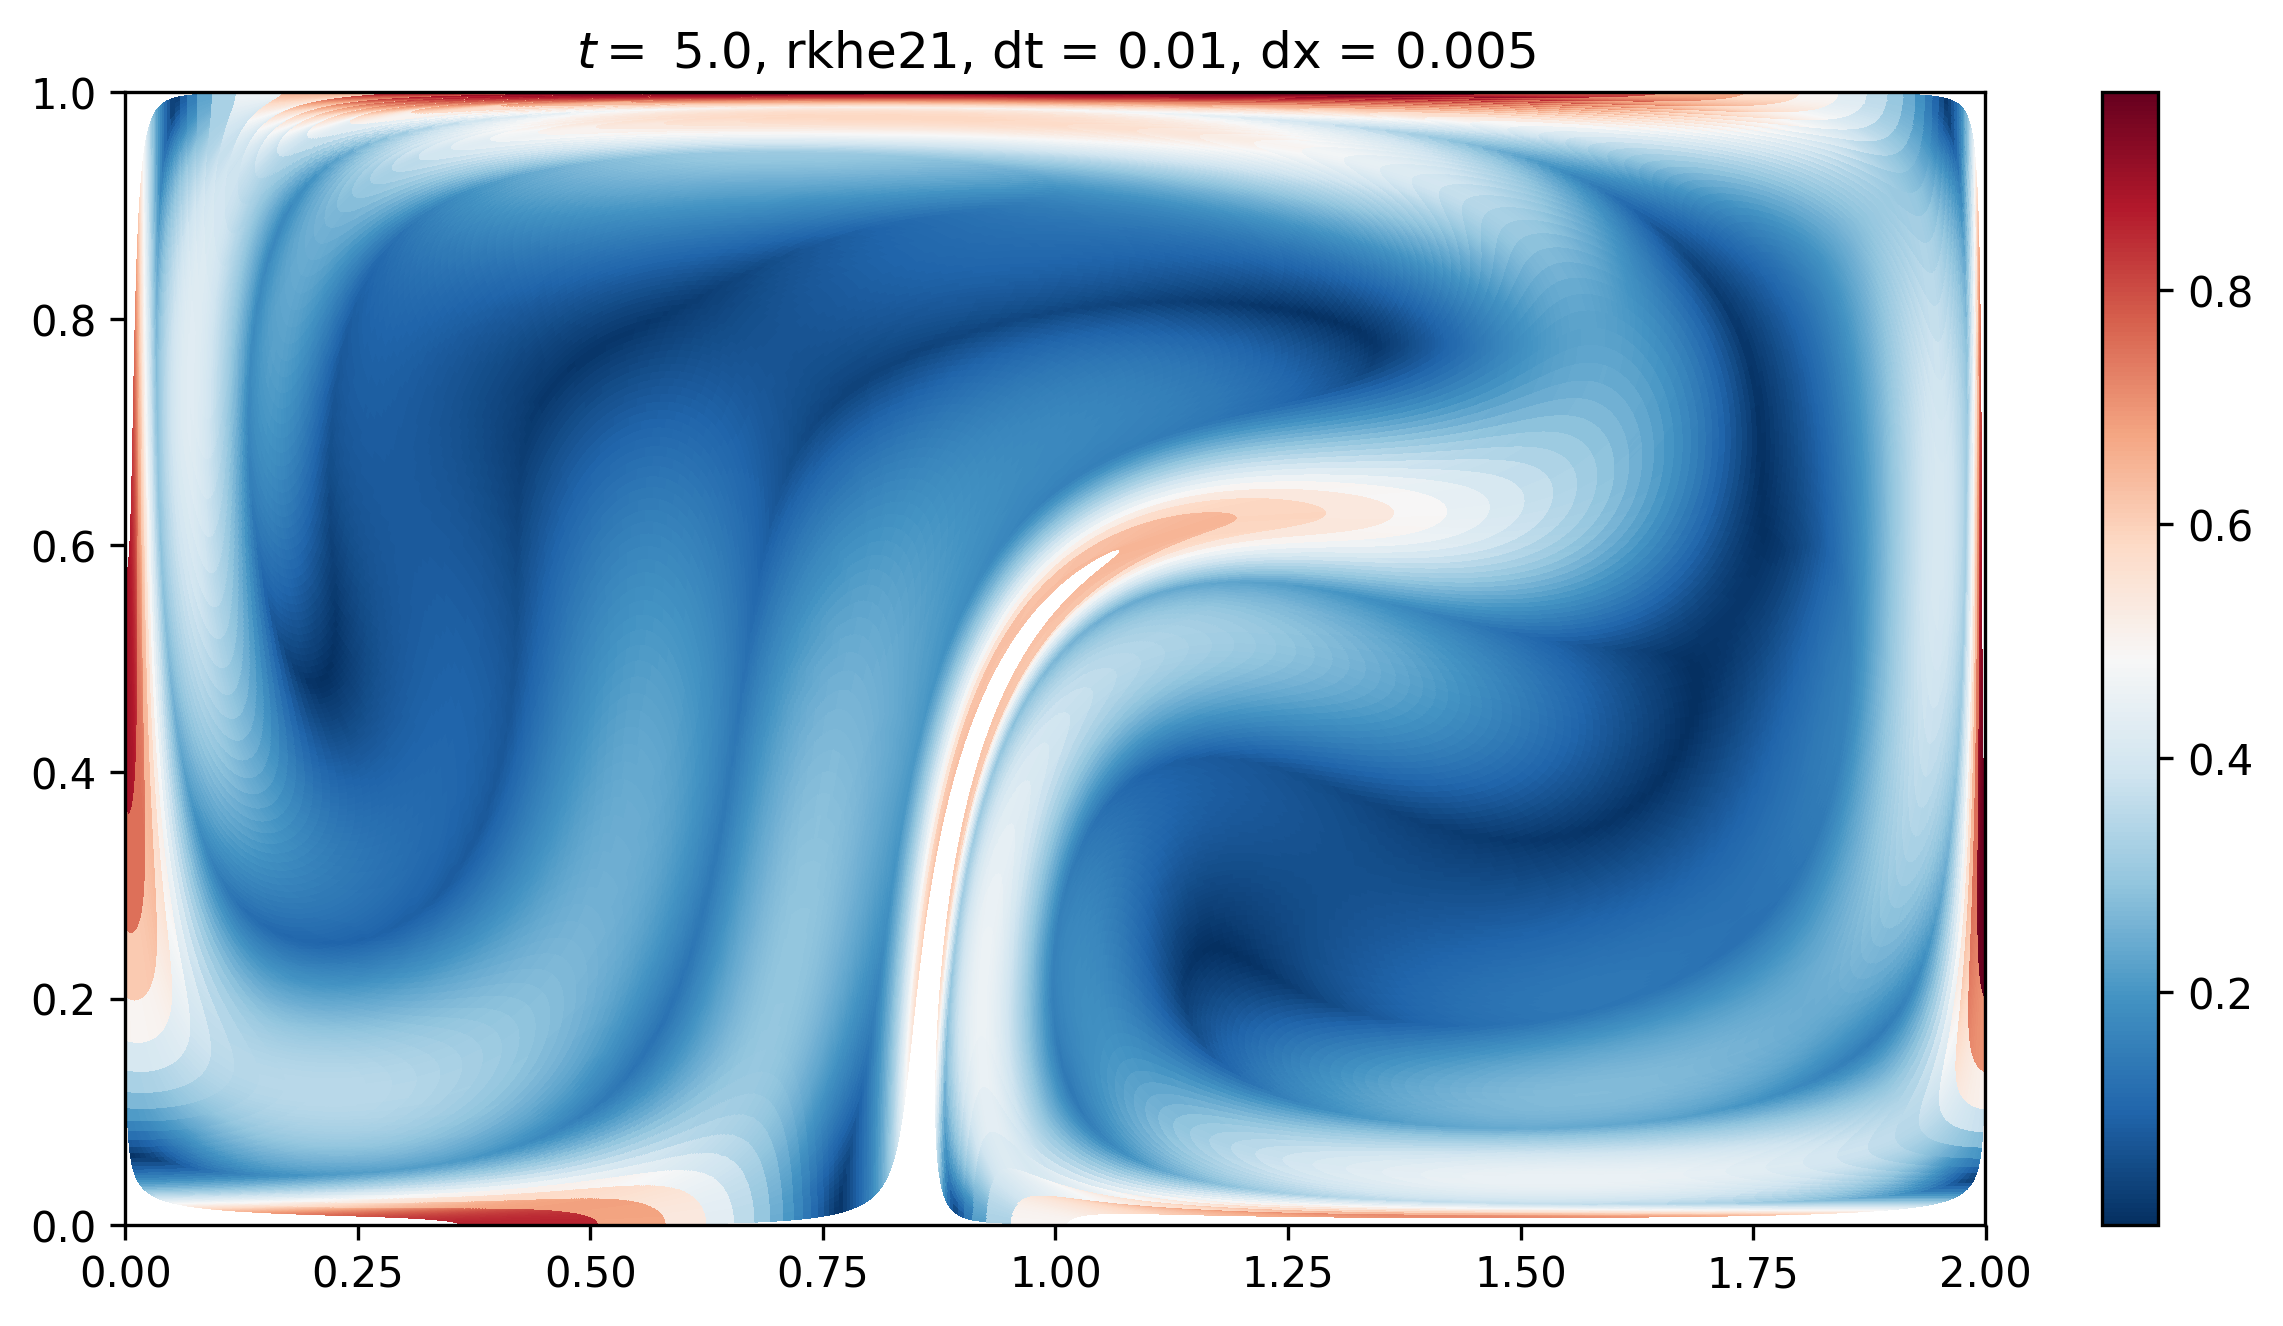

In [462]:
%matplotlib inline    
# Lastly, we need a canvas:
plt.figure(figsize=(10, 5), dpi = 300)
# We plot the calculated FTLE field:
#plt.pcolormesh(xy_ref,yx_ref,lyap,cmap='RdBu_r')
plt.pcolormesh(xy[1:-2,1:-2],1-yx[1:-2,1:-2],  lyap[1:-2,1:-2], cmap='RdBu_r')

plt.colorbar()
plt.title(r'$t=$ {}, {}, dt = {}, dx = {}'.format(t_min + (i+1)*t_incr,
                                                      integrator.__name__,
                                                      h,
                                                      dx
                                                      )
         )


# We clear the canvas, preparing for the next snapshot:
plt.show()

In [23]:
integrator = rkbs54

In [24]:
%%time
pos = np.array([x, y])
t = t_min
ts = np.ones(Nx*Ny)*t_min

hs = np.ones(np.shape(ts))*h_ref

for i in range(n_snaps):
    # We step forwards in time from one snapshot to the next:
    counter = 0
    while np.any(ts < t_min + (i+1)*t_incr):
        counter+=1
        hs = np.minimum(hs, t_min + (i+1)*t_incr - ts)

        ts, pos, hs = timestep(ts, pos, hs, vel, integrator)
        

    print(counter)

29
CPU times: user 9.68 s, sys: 0 ns, total: 9.68 s
Wall time: 9.7 s


In [25]:
%%time
pos = np.array([x, y])
t = t_min
ts = np.ones(Nx*Ny)*t_min

hs = np.ones(np.shape(ts))*h_ref

for i in range(n_snaps):
    # We step forwards in time from one snapshot to the next:
    counter = 0
    while np.any(ts < t_min + (i+1)*t_incr):
        counter += 1
        
        mask = np.less(ts, t_min + (i + 1)*t_incr)
        mask2 = np.array([mask,]*2)
        
        hs[mask] = np.minimum(hs[mask], t_min + (i+1)*t_incr - ts[mask])
        
        ts[mask], tmp, hs[mask] = timestep(ts[mask], pos[mask2].reshape(len(pos), np.sum(mask)), hs[mask], vel, integrator)
        
        pos[mask2] = tmp.flatten()
        
    print(counter)
        

29
CPU times: user 10.2 s, sys: 0 ns, total: 10.2 s
Wall time: 10.2 s


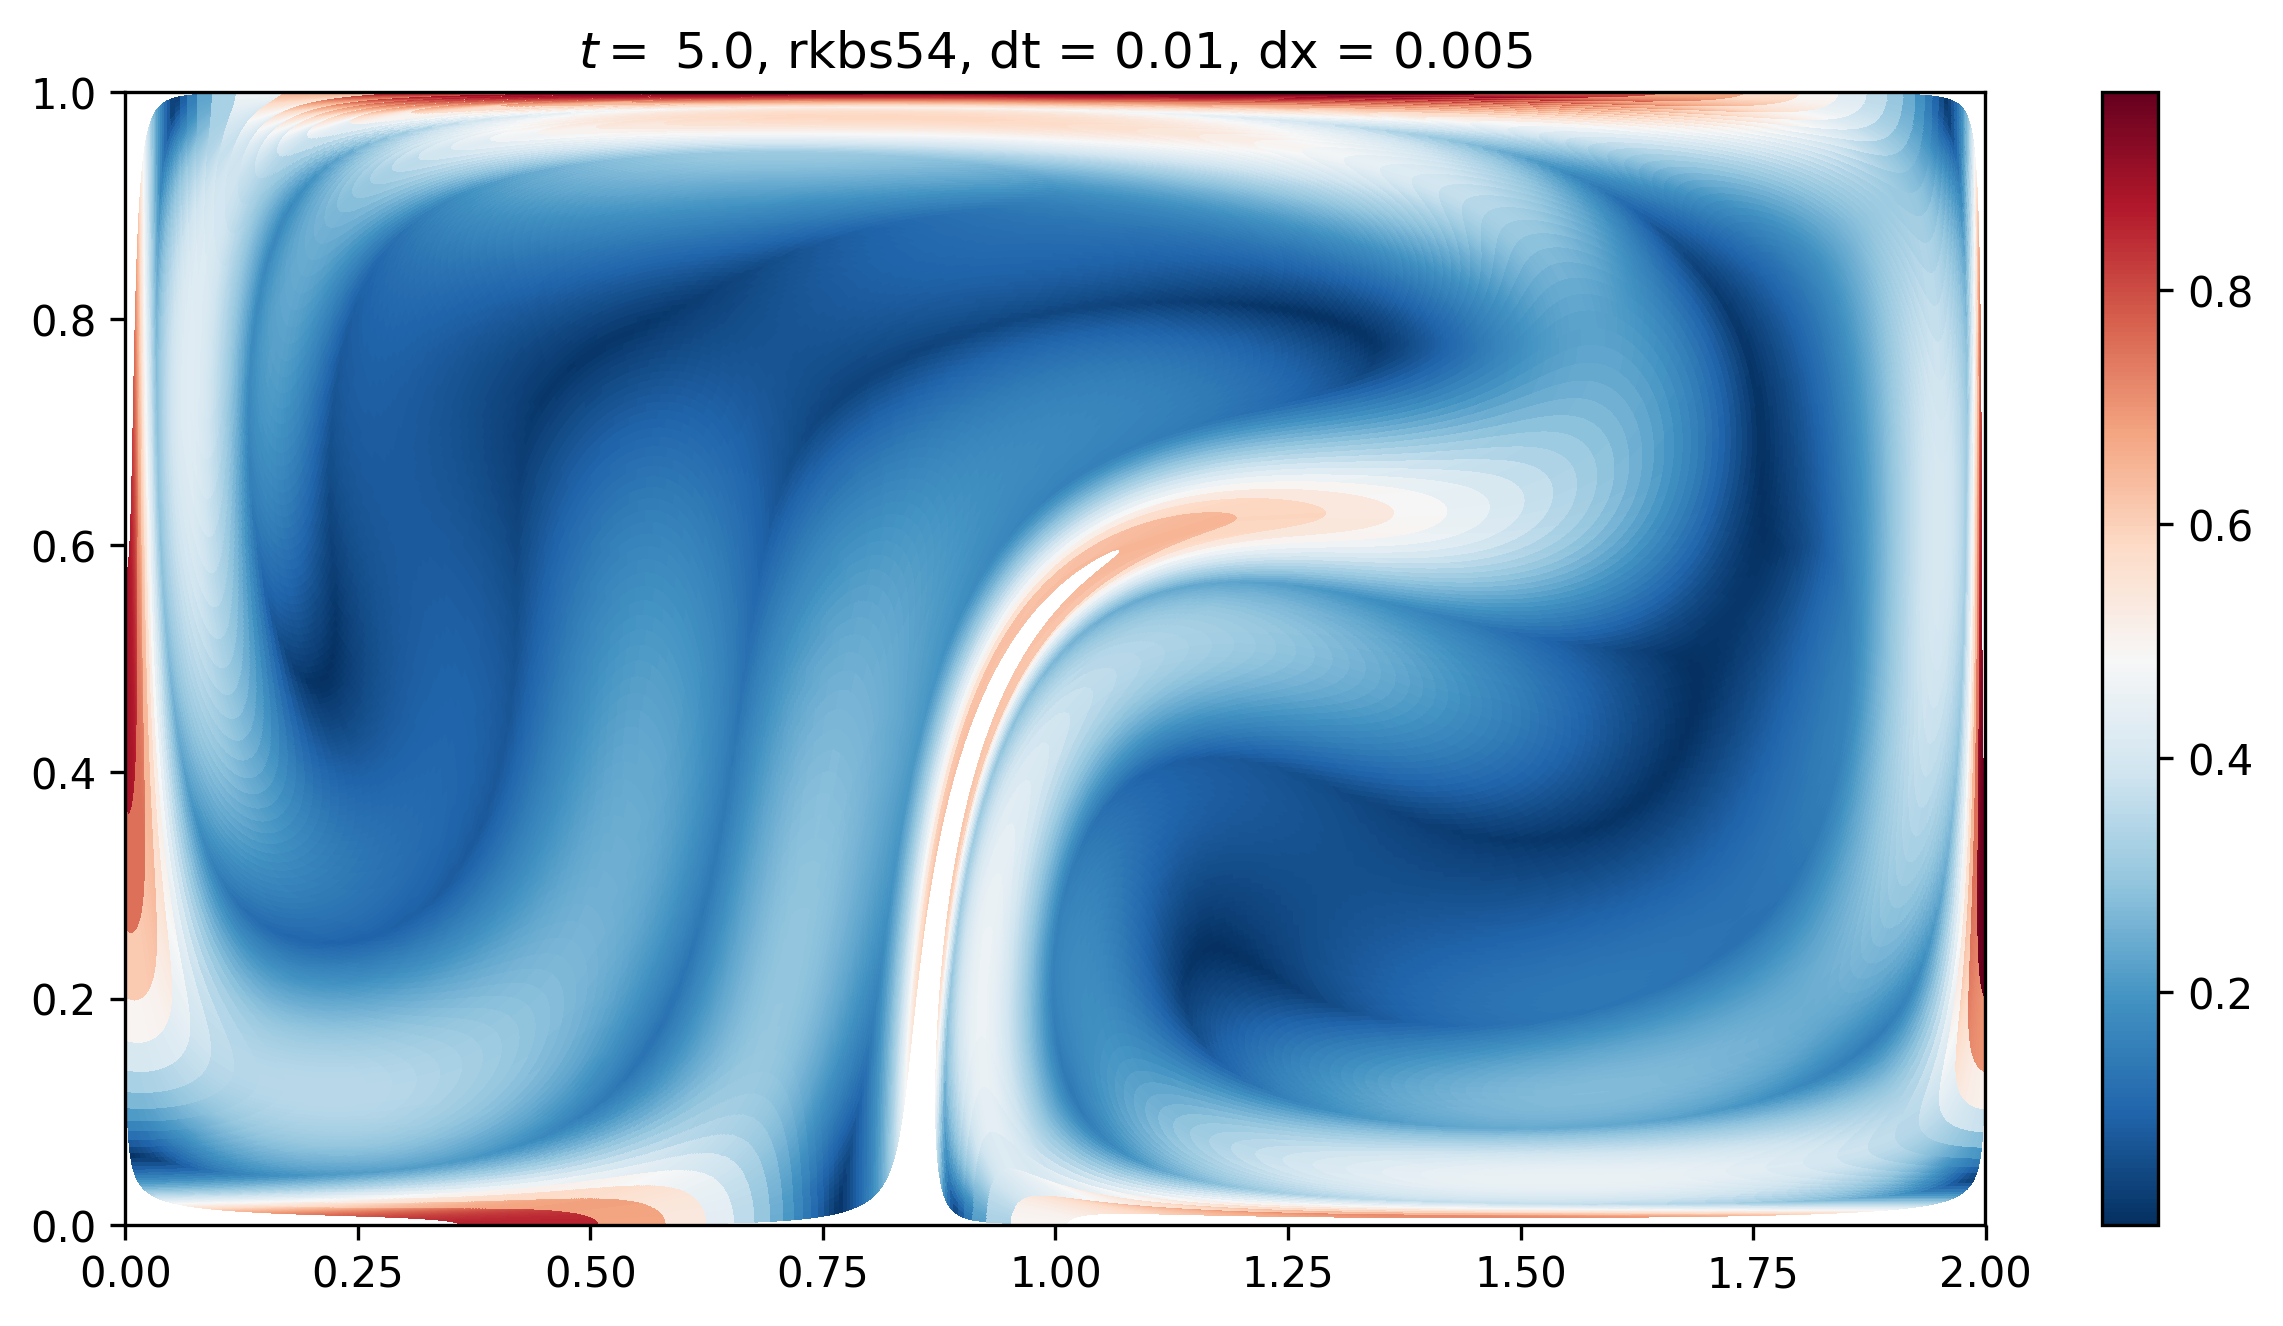

In [26]:
xy = pos[0].reshape(Ny, Nx)
yx = pos[1].reshape(Ny, Nx)

left_offset[1:-2,1:-2] = np.sqrt((xy[0:-3,1:-2]-xy[1:-2,1:-2])**2
                                    +(yx[0:-3,1:-2]-yx[1:-2,1:-2])**2)

right_offset[1:-2,1:-2] = np.sqrt((xy[2:-1,1:-2]-xy[1:-2,1:-2])**2
                                     +(yx[2:-1,1:-2]-yx[1:-2,1:-2])**2)


top_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,0:-3]-xy[1:-2,1:-2])**2
                                   +(yx[1:-2,0:-3]-yx[1:-2,1:-2])**2)

bottom_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,2:-1]-xy[1:-2,1:-2])**2
                                     +(yx[1:-2,2:-1]-yx[1:-2,1:-2])**2)

lyap = np.fmax(np.log(np.fmax(left_offset,right_offset)
                  /dx)/(t_min+(i+1)*t_incr),
                  np.log(np.fmax(top_offset,bottom_offset)
                  /dy)/(t_min+(i+1)*t_incr)
                  )

%matplotlib inline    
# Lastly, we need a canvas:
plt.figure(figsize=(10, 5), dpi = 300)
# We plot the calculated FTLE field:
#plt.pcolormesh(xy_ref,yx_ref,lyap,cmap='RdBu_r')
plt.pcolormesh(xy[1:-2,1:-2],1-yx[1:-2,1:-2],  lyap[1:-2,1:-2], cmap='RdBu_r')

plt.colorbar()
plt.title(r'$t=$ {}, {}, dt = {}, dx = {}'.format(t_min + (i+1)*t_incr,
                                                      integrator.__name__,
                                                      h,
                                                      dx
                                                      )
         )


# We clear the canvas, preparing for the next snapshot:
plt.show()

In [28]:
pos[mask2] = tmp

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [27]:
pos[mask2].shape

(32,)

In [31]:
np.shape(pos[0][mask])

(16,)

In [33]:
pos[0][mask],pos[1][mask] = tmp

In [40]:
(56-73)/73

-0.2328767123287671

In [23]:
a = np.array([True, False])
b = np.array([1, 1])

In [17]:
print(a*b)

ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [12]:
np.size(a)

2

In [13]:
ksi = np.zeros(np.size(a))

In [14]:
ksi

array([ 0.,  0.])

In [17]:
counter

275

In [26]:
b.dtype

dtype('int64')

In [29]:
b = np.array([1.])

In [30]:
b.dtype

dtype('float64')

In [34]:
a = np.finfo(float)

In [35]:
a.eps

2.2204460492503131e-16

In [9]:
a = np.array([True, False])

In [13]:
np.size(a)

2